## Data description

**Data source**: kaggle

**Objective**: to establish a model/models to predict whether a patient will have a stroke or not based on some give features. The model would be used to assist the clinical diagnosis to save cost and time for the hospital.

**Description**:

<font color='red'>id:</font> Patient ID

<font color='red'>gender:</font> Gender of patient

<font color='red'>age:</font> Age of patient

<font color='red'>hypertension:</font> 0 - no hypertension, 1 - suffering from hypertension

<font color='red'>heart_disease:</font> 0 - no heart disease, 1 - suffering from heart disease

<font color='red'>ever_married:</font> Yes/No

<font color='red'>work_type:</font> Type of occupation

<font color='red'>Residence_type:</font> Area type of residence (Urban/ Rural)

<font color='red'>avg_glucose_level:</font> Average Glucose level (measured after meal)

<font color='red'>bmi:</font> Body mass index

<font color='red'>smoking_status:</font> patient’s smoking status

<font color='red'>stroke:</font> 0 - no stroke, 1 - suffered stroke


## Imports

### Load packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.legend_handler import HandlerLine2D

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder
%matplotlib inline

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder

from statistics import mean, median

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score

from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

### Load datasets

In [2]:
train=pd.read_csv('../Data/train_2v.csv')
test=pd.read_csv('../Data/test_2v.csv')

### Overview of train and test sets

Since the model built on the train set should be generalized to the test set, we should check if the train set is representive or not. Therefore, I would like to check if the distributions of numeric features and missing patterns are similiar in both train and test sets.

In [3]:
print('train shape:', train.shape)
display(train.head())

print('test shape:', test.shape)
display(test.head())

train shape: (43400, 12)


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0


test shape: (18601, 11)


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,36306,Male,80.0,0,0,Yes,Private,Urban,83.84,21.1,formerly smoked
1,61829,Female,74.0,0,1,Yes,Self-employed,Rural,179.50,26.0,formerly smoked
2,14152,Female,14.0,0,0,No,children,Rural,95.16,21.2,NaN
3,12997,Male,28.0,0,0,No,Private,Urban,94.76,23.4,NaN
4,40801,Female,63.0,0,0,Yes,Govt_job,Rural,83.57,27.6,never smoked


In [4]:
print('*** train. describe ***')
display(train.describe())

print('*** test. describe ***')
display(test.describe())

*** train. describe ***


,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,43400.000000,43400.000000,43400.000000,43400.000000,43400.000000,41938.000000,43400.000000
mean,36326.142350,42.217894,0.093571,0.047512,104.482750,28.605038,0.018041
std,21072.134879,22.519649,0.291235,0.212733,43.111751,7.770020,0.133103
min,1.000000,0.080000,0.000000,0.000000,55.000000,10.100000,0.000000
25%,18038.500000,24.000000,0.000000,0.000000,77.540000,23.200000,0.000000
50%,36351.500000,44.000000,0.000000,0.000000,91.580000,27.700000,0.000000
75%,54514.250000,60.000000,0.000000,0.000000,112.070000,32.900000,0.000000
max,72943.000000,82.000000,1.000000,1.000000,291.050000,97.600000,1.000000


*** test. describe ***


,id,age,hypertension,heart_disease,avg_glucose_level,bmi
count,18601.000000,18601.000000,18601.000000,18601.000000,18601.000000,18010.000000
mean,36747.368045,42.056504,0.093167,0.048062,104.386359,28.545325
std,21053.151124,22.528018,0.290674,0.213903,42.606714,7.757092
min,2.000000,0.080000,0.000000,0.000000,55.000000,10.200000
25%,18542.000000,24.000000,0.000000,0.000000,77.550000,23.300000
50%,36717.000000,43.000000,0.000000,0.000000,91.830000,27.700000
75%,55114.000000,60.000000,0.000000,0.000000,112.310000,32.800000
max,72942.000000,82.000000,1.000000,1.000000,275.720000,88.300000


From the above two describe_tables, the distributions of numeric features are quite similar in both train and test sets.

In [5]:
print('*** train. info ***')
display(train.info())

print('*** test. info ***')
display(test.info())

*** train. info ***
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43400 entries, 0 to 43399
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 43400 non-null  int64  
 1   gender             43400 non-null  object 
 2   age                43400 non-null  float64
 3   hypertension       43400 non-null  int64  
 4   heart_disease      43400 non-null  int64  
 5   ever_married       43400 non-null  object 
 6   work_type          43400 non-null  object 
 7   Residence_type     43400 non-null  object 
 8   avg_glucose_level  43400 non-null  float64
 9   bmi                41938 non-null  float64
 10  smoking_status     30108 non-null  object 
 11  stroke             43400 non-null  int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 4.0+ MB


None

*** test. info ***
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18601 entries, 0 to 18600
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 18601 non-null  int64  
 1   gender             18601 non-null  object 
 2   age                18601 non-null  float64
 3   hypertension       18601 non-null  int64  
 4   heart_disease      18601 non-null  int64  
 5   ever_married       18601 non-null  object 
 6   work_type          18601 non-null  object 
 7   Residence_type     18601 non-null  object 
 8   avg_glucose_level  18601 non-null  float64
 9   bmi                18010 non-null  float64
 10  smoking_status     12850 non-null  object 
dtypes: float64(3), int64(3), object(5)
memory usage: 1.6+ MB


None

In [6]:
train_NA=pd.DataFrame(train[['bmi','smoking_status']].isna().sum(), columns=['Count'])
train_NA['% Missing']=100*(train_NA.Count/len(train))
train_NA.sort_values(by = ['% Missing'], ascending = False, na_position = 'first')

,Count,% Missing
smoking_status,13292,30.626728
bmi,1462,3.368664


In [7]:
test_NA=pd.DataFrame(test[['bmi','smoking_status']].isna().sum(), columns=['Count'])
test_NA['% Missing']=100*(test_NA.Count/len(test))
test_NA.sort_values(by = ['% Missing'], ascending = False, na_position = 'first')

,Count,% Missing
smoking_status,5751,30.917693
bmi,591,3.177249


The two features - bmi and smoking_status have missing values in both train and test, the missing rate of them are quite similar in both train and test.

## Exploratory data analysis(EDA)
### Visualization of numeric features
Columns: id, age, bmi, avg_glucose_level
#### Check if id are unique
Patient id should be unique. Check if there are some duplicates in the dataset. 

In [8]:
train.id.nunique()

43400

In [9]:
test.id.nunique()

18601

**id for patients in both train and test are unique, so id will not be used for modeling.**

#### The distributions in train and test sets
In order to build a model which can generalize to test set, we need to make sure that data in train set is representive. 

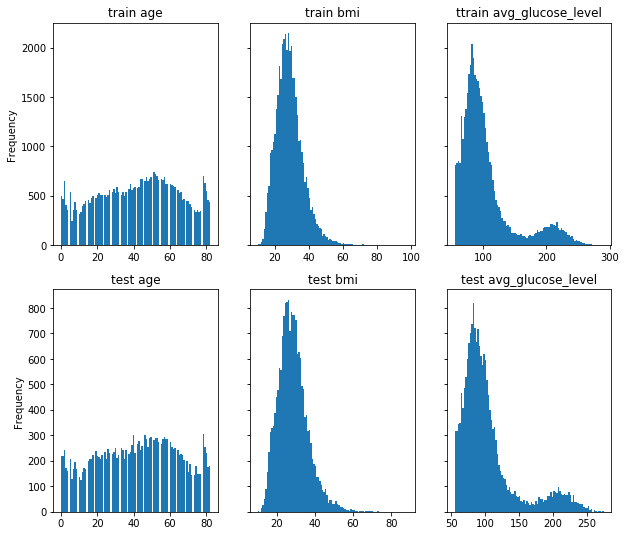

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=3, sharey= 'row', figsize=(10,9))

ax1=axes[0,0]
ax2=axes[0,1]
ax3=axes[0,2]
ax4=axes[1,0]
ax5=axes[1,1]
ax6=axes[1,2]


train.age.plot(kind='hist', bins=100, ax=ax1, log=False)
train.bmi.plot(kind='hist', bins=100,ax=ax2, log=False)
train.avg_glucose_level.plot(kind='hist', bins=100,ax=ax3, log=False)

test.age.plot(kind='hist', bins=100, ax=ax4, log=False)
test.bmi.plot(kind='hist', bins=100,ax=ax5, log=False)
test.avg_glucose_level.plot(kind='hist', bins=100,ax=ax6, log=False)

ax1.title.set_text('train age')
ax2.title.set_text('train bmi')
ax3.title.set_text('ttrain avg_glucose_level')
ax4.title.set_text('test age')
ax5.title.set_text('test bmi')
ax6.title.set_text('test avg_glucose_level')

plt.show()

The distributions of age,bmi and avg_glucose_level are quite similar in both train and test.

#### The relationship between numeric features and stroke
##### The distributions of age, bmi and avg_glucose_level labeled by stroke

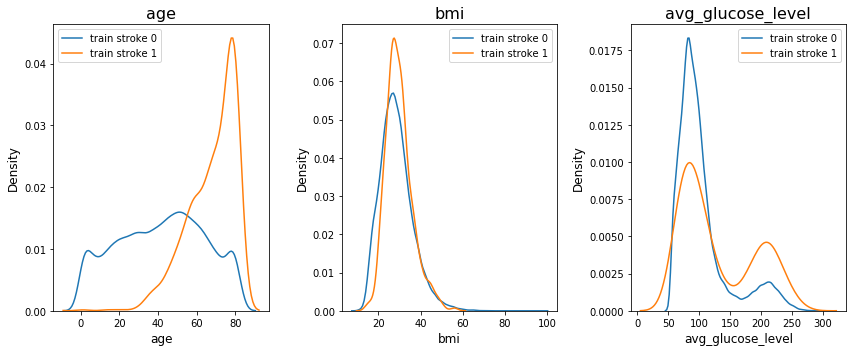

In [11]:
num_ls=['age','bmi','avg_glucose_level']

fig= plt.subplots(figsize=(12, 5))
ax1 = plt.subplot2grid((1, 3), (0, 0))
ax2 = plt.subplot2grid((1, 3), (0, 1))
ax3 = plt.subplot2grid((1, 3), (0, 2))

ax=[]
ax.extend((ax1,ax2,ax3))

for i in range(3):
    df = train[train.stroke == 0]
    sns.distplot(df[num_ls[i]], hist =False, kde = True, label='train stroke 0', ax=ax[i])
    df = train[train.stroke == 1]
    sns.distplot(df[num_ls[i]], hist =False, kde = True, label='train stroke 1', ax=ax[i])
    
    ax[i].set_xlabel(num_ls[i], fontsize=12)
    ax[i].set_ylabel('Density', fontsize=12)
    ax[i].set_title(num_ls[i], fontsize=16)
    plt.tight_layout()
    i += 1
    
plt.show()

From the above ouptput, we can get a roughly insights that:

1. As age increases, the risk of stroke goes up

2. In a specific range, such as (25, 35), the risk of stroke increases as bmi goes up

3. If avg_glucose_level is greater than 150, the risk of stroke is comparatively high.

##### Group age, bmi and avg_glucose_level 
In order to see the effect of age, bmi and avg_glucose_level on stroke clearly, I would like to group these four features seperately.

**Group age into four groups:** <font color='red'>under 20:</font> <20,  <font color='red'>young:</font> [20, 45), <font color='red'>mid age:</font> [45, 65), <font color='red'>senior:</font> >=65

**Group bmi into four groups:** <font color='red'>underweight:</font> <18.5, <font color='red'>normal:</font> [18.5, 25), <font color='red'>overweight:</font> [25, 30), <font color='red'>obese:</font> >=30

**Group avg_glucose_level into four groups:** <font color='red'>low:</font> <80, <font color='red'>normal:</font> [80, 100),  <font color='red'>high:</font> [100, 125), <font color='red'>extreme high:</font> >=125

References:
1. https://ourworldindata.org/obesity

2. https://curehighbloodsugar.blogspot.com/2020/02/low-blood-sugar-causes-in-diabetics.html

3. https://en.wikipedia.org/wiki/Middle_age#Young_adulthood

In [77]:
## Group avg_glucose_level into four groups: low, normal, high, and extreme high
train_df['glucose']='na'
train_df.loc[train_df.avg_glucose_level<80, 'glucose']='low'
train_df.loc[(train_df.avg_glucose_level>=80) & (train_df.avg_glucose_level<100), 'glucose']='normal'
train_df.loc[(train_df.avg_glucose_level>=100) & (train_df.avg_glucose_level<125), 'glucose']='high'
train_df.loc[train_df.avg_glucose_level>=125, 'glucose']='extreme high'

## Group age into four groups: under 20, young, mid-age, senior
train_df['age_group']='na'
train_df.loc[train_df.age<20, 'age_group']='under 20'
train_df.loc[(train_df.age>=20) & (train_df.age<45), 'age_group']='young'
train_df.loc[(train_df.age>=45) & (train_df.age<65), 'age_group']='mid age'
train_df.loc[train_df.age>=65, 'age_group']='senior'

## Group bim into underweight, normal, overweight, obese

train_df['bmi_group']='na'
train_df.loc[train_df.bmi<18.5, 'bmi_group']='underweight'
train_df.loc[(train_df.bmi>=18.5) & (train_df.bmi<25), 'bmi_group']='normal'
train_df.loc[(train_df.bmi>=25) & (train_df.bmi<30), 'bmi_group']='overweight'
train_df.loc[train_df.bmi>=30, 'bmi_group']='obese'


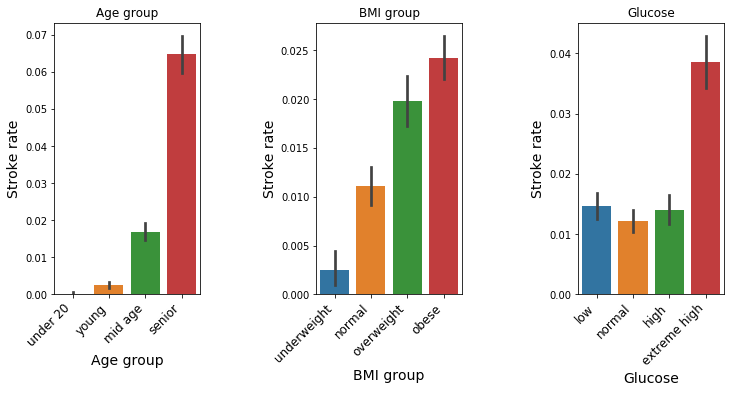

In [83]:
fig= plt.subplots(figsize=(12, 5))

ax1 = plt.subplot2grid((1, 3), (0, 0))
ax2 = plt.subplot2grid((1, 3), (0, 1))
ax3 = plt.subplot2grid((1, 3), (0, 2))
plt.subplots_adjust(wspace =0.8, hspace = 1.5) #make the figure look better

sns.barplot(x=train_df.age_group, y='stroke', data=train_df, order=['under 20','young','mid age','senior'], ax=ax1)
ax1.set_ylabel('Stroke rate', fontsize=14)
ax1.set_xlabel('Age group', fontsize=14)
ax1.set_title('Age group')
plt.setp(ax1.xaxis.get_majorticklabels(),rotation=45,horizontalalignment='right', fontsize=12)

sns.barplot(x=train_df.bmi_group, y='stroke', data=train_df, order=['underweight','normal','overweight','obese'], ax=ax2)
ax2.set_ylabel('Stroke rate', fontsize=14)
ax2.set_xlabel('BMI group', fontsize=14)
ax2.set_title('BMI group')
plt.setp(ax2.xaxis.get_majorticklabels(),rotation=45,horizontalalignment='right', fontsize=12)

sns.barplot(x=train_df.glucose, y='stroke', data=train_df, order=['low','normal','high','extreme high'], ax=ax3)
ax3.set_ylabel('Stroke rate', fontsize=14)
ax3.set_xlabel('Glucose', fontsize=14)
ax3.set_title('Glucose')
plt.setp(ax3.xaxis.get_majorticklabels(),rotation=45,horizontalalignment='right', fontsize=12)

plt.show()

From the above output, we can find that:

1. age is very important risk factor for stroke. Senior patients have much higher risk to get stroke than youner patients.

2. patients who have high bmi have comparatively higher risk to get stroke.

3. patients who have extemely high glucose level have much higher risk to get stroke than other patients.

### Visualization of categorical features
Columns: gender, hyperstension, heart_disease, ever_married, work_type, Residence_type, and smoking_status
#### The count patterns in train and test
To check if the count patterns of these features are similiar in both train and test sets.

In [13]:
num_ls=['age', 'bmi','id','avg_glucose_level']
cat_ls= [ele for ele in list(test.columns) if ele not in num_ls] 

In [14]:
cat_ls

['gender',
 'hypertension',
 'heart_disease',
 'ever_married',
 'work_type',
 'Residence_type',
 'smoking_status']

In [15]:
def count_plot(col_name, fig_size=(10,10)):
    """
    Helper function for count plot. 
    Here in count plot I have ordered by train[col].value_counts so it is easy compare distribution between train and test
    """
    fig = plt.figure(figsize=fig_size)
    fig.add_subplot(2,1,1)            
    ax1 = sns.countplot(x=col_name, data=train, order = train[col_name].value_counts().index)
    for p in ax1.patches:
        ax1.annotate('{0:.3}'.format(p.get_height()/len(train)), (p.get_x()+0.28, p.get_height()+0.8))
    ax1.set_title("Train distribution", fontsize='large')
    ax1.set_ylabel('Count')
    plt.subplots_adjust(wspace =0.8, hspace = 0.5)
    fig.add_subplot(2,1,2)            
    ax2 = sns.countplot(x=col_name, data=test, order = train[col_name].value_counts().index)
    ax2.set_title("Test distribution", fontsize='large')
    ax2.set_ylabel('Count')
    for p in ax2.patches:
        ax2.annotate('{0:.3}'.format(p.get_height()/len(test)), (p.get_x()+0.28, p.get_height()+0.5))
    
    plt.show()     

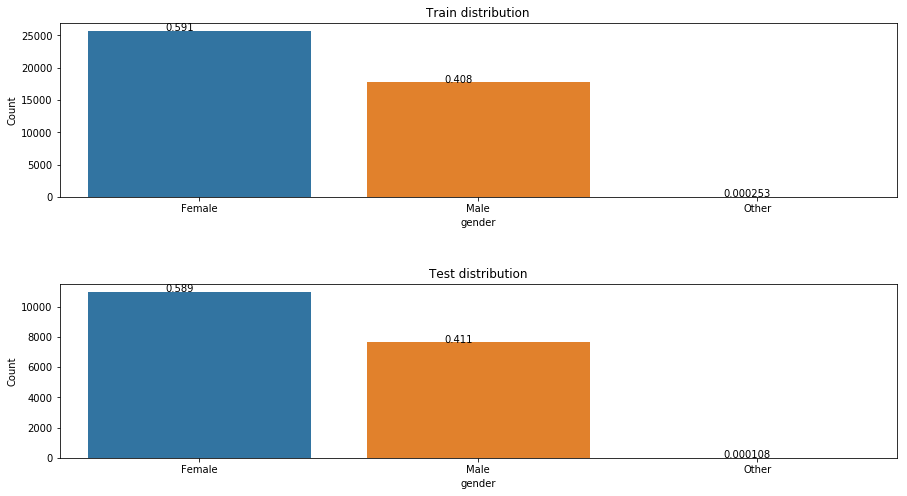

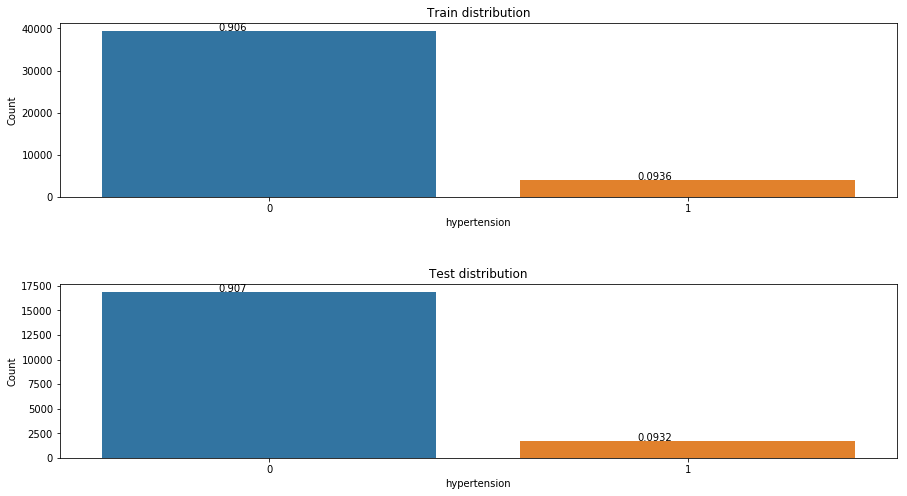

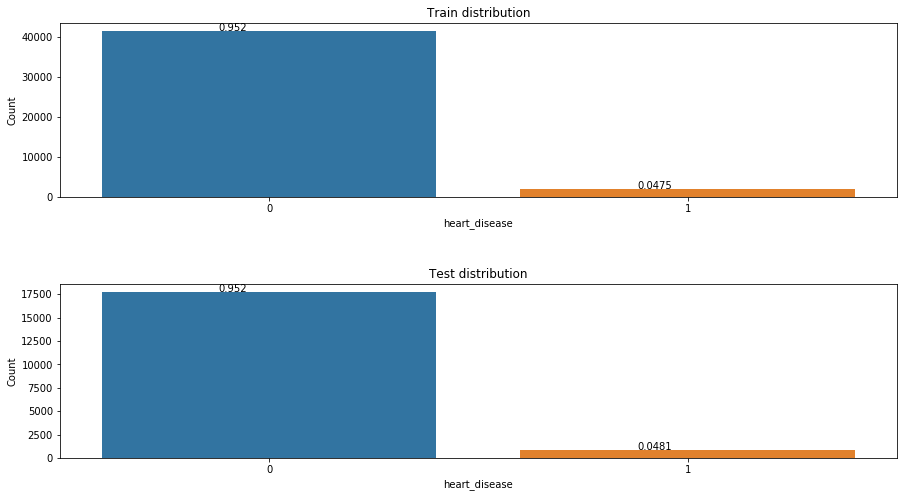

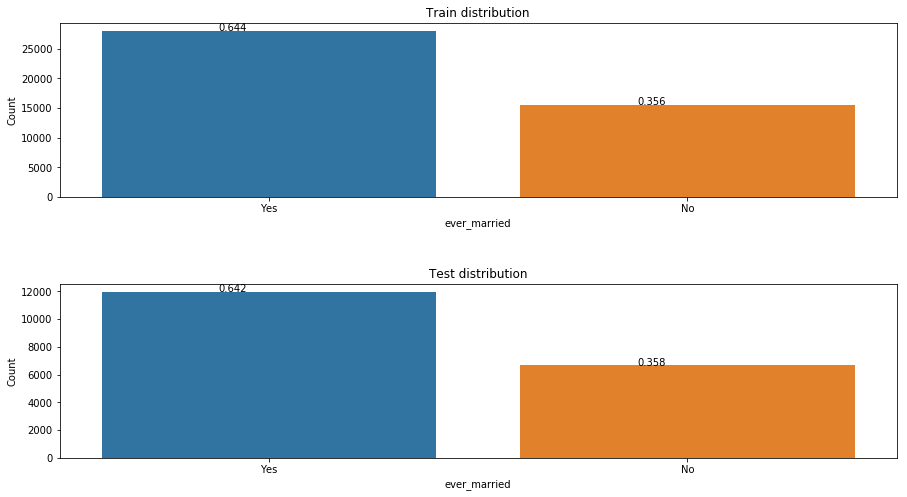

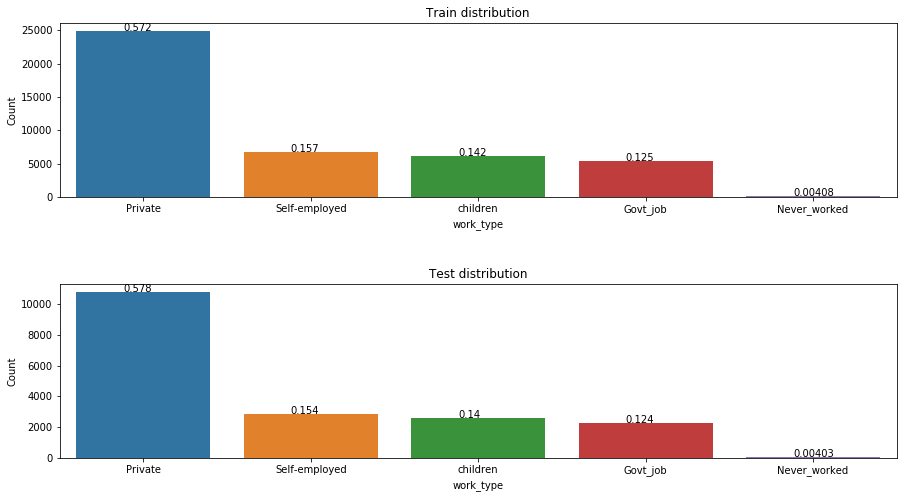

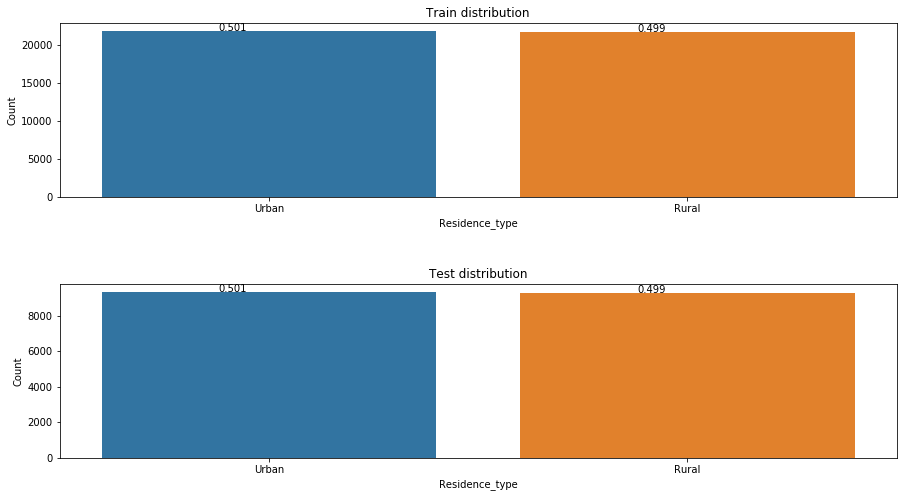

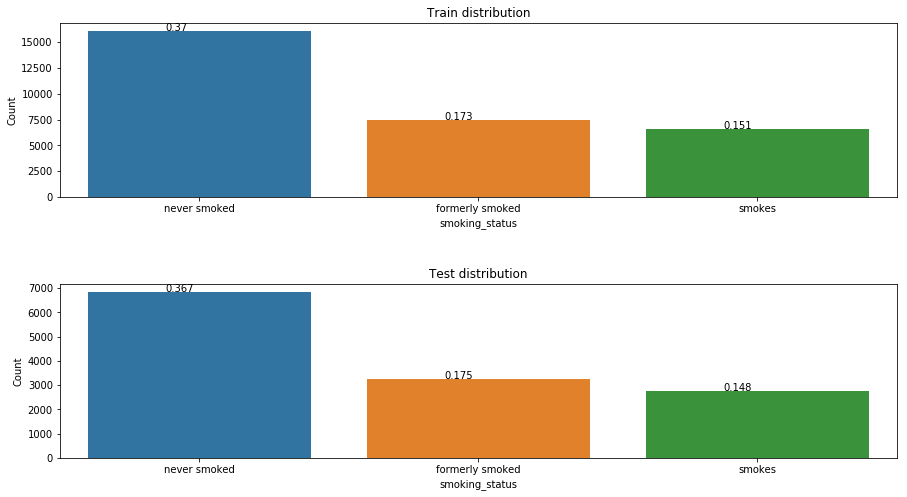

In [45]:
for i in range(7):
    count_plot(col_name =cat_ls[i], fig_size=(15,8))

#### The effect of categorical features on stroke

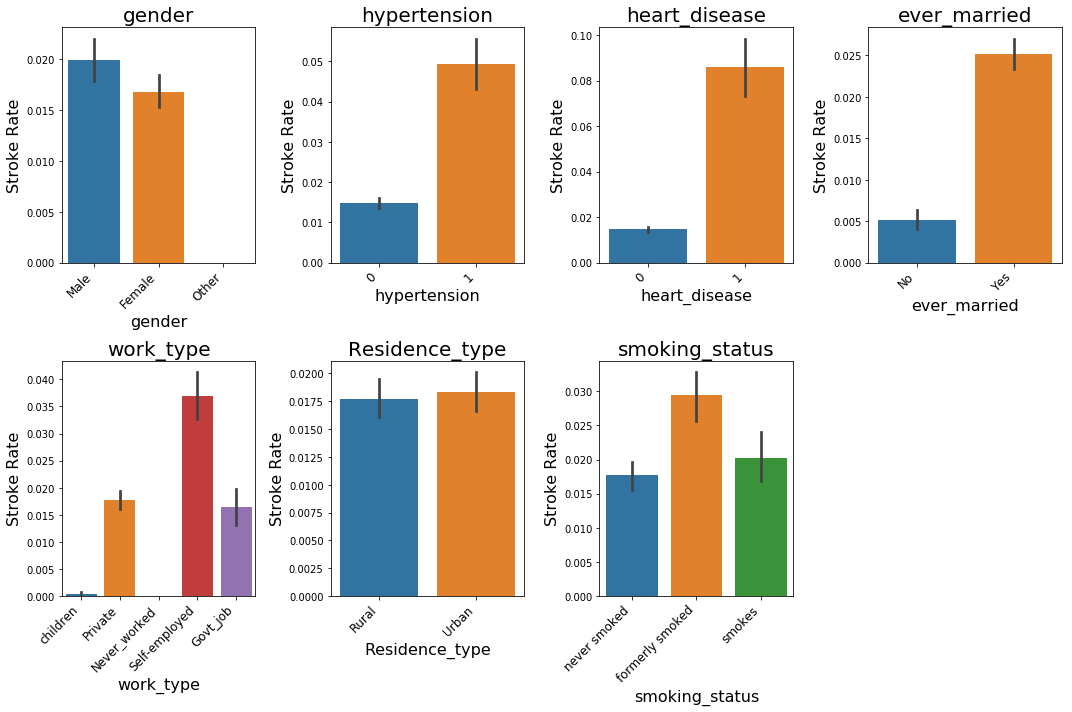

In [17]:
fig= plt.subplots(figsize=(15, 10))

ax1 = plt.subplot2grid((2, 4), (0, 0))
ax2 = plt.subplot2grid((2, 4), (0, 1))
ax3 = plt.subplot2grid((2, 4), (0, 2))
ax4 = plt.subplot2grid((2, 4), (0, 3))
ax5 = plt.subplot2grid((2, 4), (1, 0))
ax6 = plt.subplot2grid((2, 4), (1, 1))
ax7 = plt.subplot2grid((2, 4), (1, 2))

ax=[]
ax.extend((ax1,ax2,ax3,ax4,ax5,ax6,ax7))

plt.subplots_adjust(wspace =0.8, hspace = 1.5) #make the figure look better

for i in range(7):
    sns.barplot(x=train[cat_ls[i]], y='stroke', data=train, ax=ax[i])
    ax[i].set_xlabel(cat_ls[i], fontsize=16)
    ax[i].set_ylabel('Stroke Rate', fontsize=16)
    ax[i].set_title(cat_ls[i], fontsize=20)
    plt.setp(ax[i].xaxis.get_majorticklabels(),rotation=45,horizontalalignment='right', fontsize=12)
    
    plt.tight_layout()
    i += 1

plt.show()

From the above figures, we can find that:
1. If a patient who has **hypertension** or **heart_disease** has a higher risk to get stroke.
2. If a patient who **ever married** has a higher risk to get stroke. **Instresting!!!**
3. Different work_type may indicate different stress level. **Self_employed** patients have a higher risk to get stroke than others. 
4. **Smoking_status** also affect the risk of stroke.
5. **Male** have slightly higher risk to get stroke than female
6. **Residence_type** seems not have obvious effect on stroke

### Imbalanced target
The base rate of stroke is only 1.8%, so the data set is very imbalanced. Must keep this in mind when train models in the following steps.

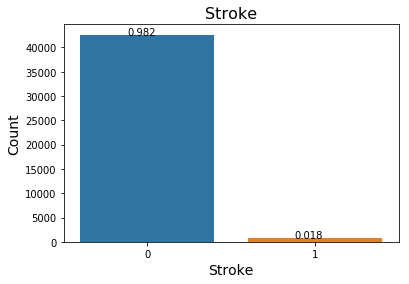

In [92]:
ax1 = sns.countplot(x='stroke', data=train, order = train.stroke.value_counts().index)
for p in ax1.patches:
    ax1.annotate('{0:.3}'.format(p.get_height()/len(train)), (p.get_x()+0.28, p.get_height()+0.8))
ax1.set_title("Stroke", fontsize='16')
ax1.set_ylabel('Count', fontsize='14')
ax1.set_xlabel('Stroke',fontsize='14')

plt.show()

## Data proprocessing
### Age vs work_type, correct unreasonale values for work_type

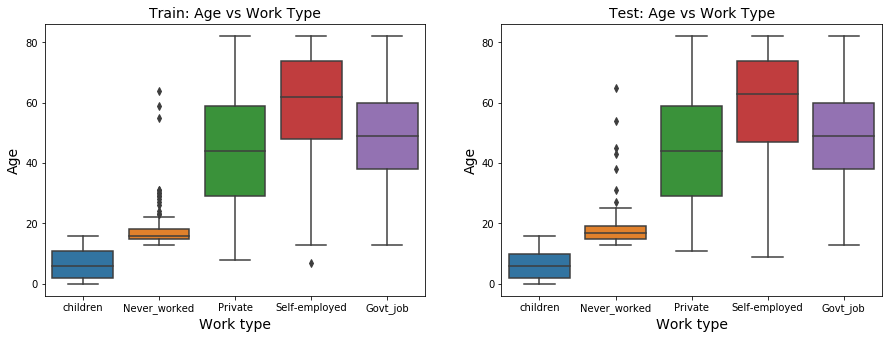

In [18]:
fig= plt.subplots(figsize=(15, 5))

ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))


#plt.subplots_adjust(wspace =1, hspace = 0.1)

sns.boxplot(x='work_type', y='age', data=train, ax=ax1, order=['children','Never_worked', 'Private', 'Self-employed','Govt_job'])
ax1.set_xlabel('Work type',fontsize=14)
ax1.set_ylabel('Age', fontsize=14)
ax1.set_title('Train: Age vs Work Type',fontsize=14)
#plt.setp(ax1.xaxis.get_majorticklabels(),rotation=45,horizontalalignment='right', fontsize=12)

sns.boxplot(x='work_type', y='age', data=test, ax=ax2, order=['children','Never_worked', 'Private', 'Self-employed','Govt_job'])
ax2.set_xlabel('Work type',fontsize=14)
ax2.set_ylabel('Age', fontsize=14)
ax2.set_title('Test: Age vs Work Type',fontsize=14)
#plt.setp(ax1.xaxis.get_majorticklabels(),rotation=45,horizontalalignment='right', fontsize=12)

plt.show()


From the above output, we found that many patients with age under 18 were grouped into never_worked, private, self-employed or govt_job. Personaly, I think patients under 18 should be grouped into children. 

In [19]:
train_df=train.copy()
train_df.loc[train_df.age<18, 'work_type']='children'

test_df=test.copy()
test_df.loc[test_df.age<18, 'work_type']='children'

### Handle missing values 
#### Missing values in smoking status

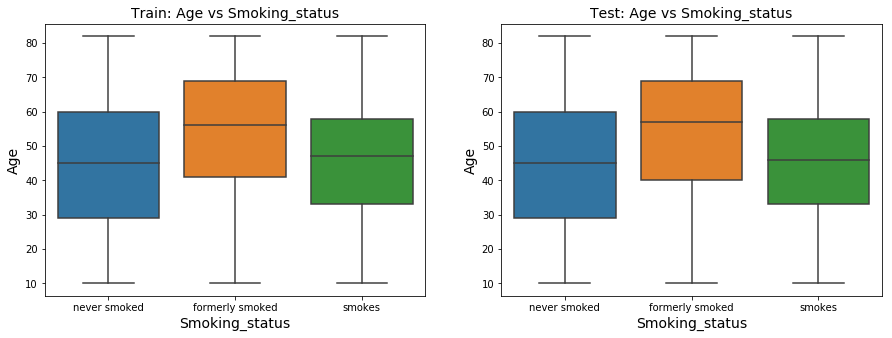

In [21]:
fig= plt.subplots(figsize=(15, 5))

ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))

sns.boxplot(x='smoking_status', y='age', data=train, ax=ax1, order=['never smoked','formerly smoked', 'smokes'])
ax1.set_xlabel('Smoking_status',fontsize=14)
ax1.set_ylabel('Age', fontsize=14)
ax1.set_title('Train: Age vs Smoking_status',fontsize=14)

sns.boxplot(x='smoking_status', y='age', data=test, ax=ax2,order=['never smoked','formerly smoked', 'smokes'])
ax2.set_xlabel('Smoking_status',fontsize=14)
ax2.set_ylabel('Age', fontsize=14)
ax2.set_title('Test: Age vs Smoking_status',fontsize=14)

plt.show()

In [22]:
len(train[train.age <10].smoking_status.isna())

4285

In [84]:
len(train[train.age <10].smoking_status)

4285

From above output, we can find that the values for smoking_status of patients under 10 are missing. In common sense, people under 10 are not possible to smoke. So I would like to fill the these missing values with 'never smoked'.

In [24]:
train_df.loc[train_df.age<10, 'smoking_status']='never smoked'

test_df.loc[test_df.age<10, 'smoking_status']='never smoked'

The total missing rates of smoking_status in both train and test sets are around 30%. Although the missing values for those patient under 10 were filled with 'never smoked', there are still 20% missing values. I'm not sure the reason for the missing, I would like to use 'unknown' to fill the missing values.

In [26]:
train_df.loc[train_df.smoking_status.isna(), 'smoking_status']='unknown'

test_df.loc[test_df.smoking_status.isna(), 'smoking_status']='unknown'

### Handle missing values in bmi

Sine there are only 3% missing values in bmi, I would like to use median to fill na.

In [27]:
train_df.loc[train_df.bmi.isna(), 'bmi'] =median(train_df.bmi)
test_df.loc[test_df.bmi.isna(), 'bmi'] = median(train_df.bmi)

### Transformation for categorical features

LabelEncoder for gender, ever_married, work_type, Residence_type and smoking_status

In [32]:
categorical_features=['gender', 'ever_married', 'work_type','Residence_type','smoking_status']
print('Transform all String features to category.\n')
for usecol in categorical_features:
    train_df[usecol] = train_df[usecol].astype('str')
    test_df[usecol] = test_df[usecol].astype('str')
    
    #Fit LabelEncoder
    le = LabelEncoder().fit(
            np.unique(train_df[usecol].unique().tolist()+
                      test_df[usecol].unique().tolist()))

    #At the end 0 will be used for null values so we start at 1 
    train_df[usecol] = le.transform(train_df[usecol])+1
    test_df[usecol]  = le.transform(test_df[usecol])+1
    
    train_df[usecol] = train_df[usecol].replace(np.nan, 0).astype('int').astype('category')
    test_df[usecol]  = test_df[usecol].replace(np.nan, 0).astype('int').astype('category')

Transform all String features to category.



## Data modeling
Split train into new train and validation sets

In [105]:
X=train_df.copy()
X=X.drop(columns=['id','stroke','glucose','age_group','bmi_group'])
y=train_df.stroke

X_test=test_df.copy()
X_test=X_test.drop(columns=['id','glucose'])

## split X_train into training and validation 
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=2019)

### RandomForest classifier
RandomForest classifier is a tree-based algorithm, it has the following advantages:
1. robust to outliers.
2. quick train/prediction speed.
3. provides the scores about feature importance, which can let you know the relationship features have with the target and the degree of influence they have on target.

#### Baseline of RandomForest classifier
Since the data is very imbalaned, I set class_weight='balance' to put weights for each class. The formula of the weight for each class is n_samples / (n_classes * np.bincount(y)).

In [34]:
# Instantiate an RandomForestClassifier with default hyperparameter settings
rf = RandomForestClassifier(class_weight='balanced') ## Since base rate of shroke is very rare, data should be balanced

# compute a baseline to beat with hyperparameter optimization 
rf_baseline_train = cross_val_score(rf, X_train, y_train, scoring='roc_auc', cv=10).mean()
rf_baseline_val = cross_val_score(rf, X_val, y_val, scoring='roc_auc',cv=10).mean()

print('train_rf_baseline ROC_AUC: {0:.3}'.format(rf_baseline_train))
print('val_rf_baseline ROC_AUC: {0:.3}'.format(rf_baseline_val))

train_rf_baseline ROC_AUC: 0.635
val_rf_baseline ROC_AUC: 0.605


### Tune hyperparameters of RandomForest classifier
BayesianOptimization for hyperparameters tuning.

What does BayesianOptimization do?

Build a probability model of the objective function and use it to select the most promising hyperparameters to evaluate in the true objective function.

Advantages compared to GridSearch and RandomSearch:
1. quick tuning speed
2. search space is large and continous

In [38]:
def rf_evaluate( n_estimators, max_depth, min_samples_split, min_samples_leaf,max_leaf_nodes): 
    rf_params = {  'n_estimators': int(n_estimators),                                                              
                   'max_depth': int(max_depth),
                   'min_samples_split':int(min_samples_split), 
                   'min_samples_leaf':int(min_samples_leaf),
                   'max_leaf_nodes':int(max_leaf_nodes),
                   'n_jobs':-1, 
                   'random_state':42 
               }
     # Used around 1000 boosting rounds in the full model
    cv_result= cross_val_score(RandomForestClassifier(**rf_params, class_weight='balanced'),  ## ** unpack params for the function call
               X=X_train, 
               y=y_train, 
               cv=10,
               scoring='roc_auc',
               n_jobs=-1).mean()   
    return cv_result

rf_params = {"n_estimators": (10, 300),
            "max_depth": (3, 20),
            "min_samples_split": (2, 15),
            'min_samples_leaf':(2,20),
            "max_leaf_nodes": (20, 40)
            }


rf_bo = BayesianOptimization(rf_evaluate , rf_params)

In [39]:
rf_bo.maximize(init_points=5, n_iter=5, acq='ei')

|   iter    |  target   | max_depth | max_le... | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------
|  1        |  0.8505   |  14.12    |  23.2     |  19.52    |  5.331    |  58.05    |
|  2        |  0.8516   |  16.95    |  32.06    |  6.218    |  8.09     |  156.6    |
|  3        |  0.8517   |  15.7     |  34.44    |  15.57    |  9.688    |  276.9    |
|  4        |  0.8508   |  9.903    |  35.74    |  6.441    |  2.811    |  154.4    |
|  5        |  0.8493   |  5.37     |  24.07    |  8.603    |  7.993    |  251.6    |
|  6        |  0.8472   |  19.76    |  38.13    |  11.51    |  11.91    |  10.3     |
|  7        |  0.8518   |  19.65    |  21.74    |  16.78    |  2.438    |  299.7    |
|  8        |  0.8517   |  19.58    |  25.01    |  18.7     |  2.49     |  299.8    |
|  9        |  0.8522   |  18.99    |  35.34    |  19.15    |  2.171    |  299.6    |
|  10       |  0.8471   |  3.186    |  20.04    |  19.

Get the best hyperparameters

In [40]:
## get the best parameters 
rf_params = rf_bo.max['params']

print(rf_params)

{'max_depth': 18.988367117508737, 'max_leaf_nodes': 35.33715960328179, 'min_samples_leaf': 19.14687658522414, 'min_samples_split': 2.1707402983320327, 'n_estimators': 299.58402859131553}


Fit model with best hyperparameters and test the model performance on validation set.

In [41]:
rf_tuned = RandomForestClassifier(max_depth=18, 
                                  min_samples_split=2, 
                                  n_estimators= 299, 
                                  min_samples_leaf=19,
                                  max_leaf_nodes=35,
                                  class_weight='balanced')
                                 
rf_tuned = rf_tuned.fit(X_train, y_train)

rf_tuned_train_ROC_AUC = cross_val_score(rf_tuned, X_train, y_train, scoring='roc_auc').mean()
rf_tuned_val_ROC_AUC = cross_val_score(rf_tuned, X_val, y_val, scoring='roc_auc').mean()

print('train_rf_baseline ROC_AUC: {0:.3}'.format(rf_baseline_train))
print('train_rf_tuned ROC_AUC: {0:.3}'.format(rf_tuned_train_ROC_AUC))

print(' ')

print('val_rf_baseline ROC_AUC: {0:.3}'.format(rf_baseline_val))
print('val_rf_tuned ROC_AUC: {0:.3}'.format(rf_tuned_val_ROC_AUC))

train_rf_baseline ROC_AUC: 0.635
train_rf_tuned ROC_AUC: 0.854
 
val_rf_baseline ROC_AUC: 0.605
val_rf_tuned ROC_AUC: 0.827


After tuning, the performance of RandomForest classifier has been improved a lot, comparing to the baseline RandomForest classifier.

#### Plot of  Feature importance

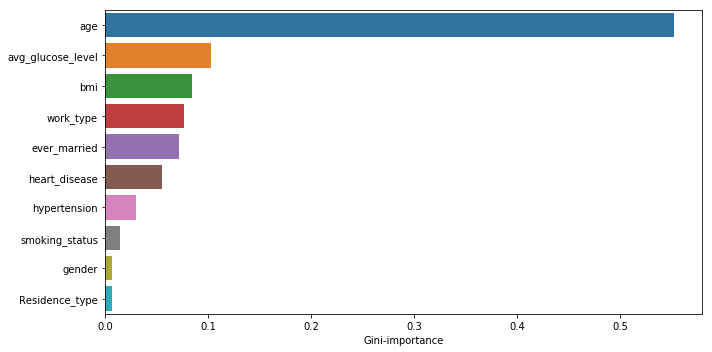

In [43]:
rf_fscores=pd.DataFrame(rf_tuned.feature_importances_)

feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_train.columns, rf_tuned.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})

plt.figure(figsize=(10, 5))
importances=importances.sort_values(by='Gini-importance', ascending=False)
sns.barplot(x='Gini-importance', y=importances.index, data=importances)
plt.tight_layout()
plt.show()

The influece of each features is roughly consistent with the insights based on data visualiztion.

### Light GBM classifier
Light GBM Classifier is a gradient tree-based algorithm, it has the following advantages:

1. Higher efficiency as well as faster training speed
2. Usage of lower memory
3. Supports Parallel and GPU learning
4. Data of large-scale can be handled

#### Base line of light GBM classifier

In [46]:
# Instantiate an RandomForestClassifier with default hyperparameter settings
lgb = LGBMClassifier(class_weight='balanced') ## Since base rate of cliked=1 is very rare, data should be balanced

# compute a baseline to beat with hyperparameter optimization 
lgb_baseline_train = cross_val_score(lgb, X_train, y_train, scoring='roc_auc', cv=10).mean()
lgb_baseline_val = cross_val_score(lgb, X_val, y_val, scoring='roc_auc',cv=10).mean()

print('train_lgb_baseline ROC_AUC: {0:.3}'.format(lgb_baseline_train))
print('val_lgb_baseline ROC_AUC: {0:.3}'.format(lgb_baseline_val))

train_lgb_baseline ROC_AUC: 0.844
val_lgb_baseline ROC_AUC: 0.8


#### Tune hyperparameters of light GBM classifier
Tune light GBM classifier with BayesianOptimization

In [47]:
def lgb_evaluate( n_estimators, max_depth, learning_rate,colsample_bytree,subsample,reg_lambda): 
    lgb_params = {  'n_estimators': int(n_estimators),                                                              
                   'max_depth': int(max_depth),
                   'learning_rate':learning_rate,
                  'colsample_bytree':colsample_bytree,
                  'subsample':subsample,
                  'reg_alpha':0, #L1 regularization term on weights
                  'reg_lambda':reg_lambda, #L2 regularization term on weights
                   'n_jobs':-1, 
                   'random_state':42,
                  'objective':'binary',
                  'importance_type':'gain'
               }
     # Used around 1000 boosting rounds in the full model
    cv_result= cross_val_score(LGBMClassifier(**lgb_params, class_weight='balanced'),  ## ** unpack params for the function call
               X=X_train, 
               y=y_train, 
               cv=10,
               scoring='roc_auc',
               n_jobs=-1).mean()   
    return cv_result

lgb_params = {"n_estimators": (10, 300),
                  "max_depth": (3, 20),
                  'learning_rate':(0.01,0.03),
                  'colsample_bytree':(0.4,1),
                  'subsample':(0.4,1),
                  #'reg_alpha':(0,1),
                  'reg_lambda':(0,5)
             }


lgb_bo = BayesianOptimization(lgb_evaluate , lgb_params)

In [74]:
lgb_bo.maximize(init_points=5, n_iter=5, acq='ei')

|   iter    |  target   | colsam... | learni... | max_depth | n_esti... | reg_la... | subsample |
-------------------------------------------------------------------------------------------------
|  1        |  0.8488   |  0.744    |  0.01939  |  4.566    |  62.74    |  3.144    |  0.55     |
|  2        |  0.8578   |  0.634    |  0.02958  |  4.721    |  126.3    |  1.431    |  0.5912   |
|  3        |  0.8557   |  0.7947   |  0.02306  |  12.84    |  293.4    |  1.498    |  0.7734   |
|  4        |  0.8589   |  0.5908   |  0.01484  |  16.07    |  260.8    |  3.875    |  0.4574   |
|  5        |  0.8563   |  0.4172   |  0.026    |  18.82    |  246.8    |  3.465    |  0.4424   |
|  6        |  0.8537   |  0.8813   |  0.01171  |  3.15     |  216.4    |  4.941    |  0.7612   |
|  7        |  0.8576   |  0.9093   |  0.02208  |  19.95    |  165.2    |  0.06203  |  0.4148   |
|  8        |  0.8566   |  0.803    |  0.01048  |  19.88    |  133.0    |  4.98     |  0.5973   |
|  9        |  0.856

Get the best hyperparameters

In [75]:
## get the best parameters 
lgb_params = lgb_bo.max['params']

print(lgb_params)

{'colsample_bytree': 0.5908326310981642, 'learning_rate': 0.014837139130604717, 'max_depth': 16.065483071127616, 'n_estimators': 260.7672015162233, 'reg_lambda': 3.87501304610299, 'subsample': 0.4573772512014622}


Fit lgiht GBM classifier with best hyperparameters

In [76]:
lgb_tuned = LGBMClassifier(colsample_bytree=0.5908326310981642, 
                                   learning_rate= 0.014837139130604717, 
                                   max_depth= 16,
                                   n_estimators= 260,  
                                   reg_lambda= 3.87501304610299, 
                                   subsample=  0.4573772512014622,
                                   class_weight='balanced',
                                   importance_type='gain',
                                   objective='binary')
                                 
lgb_tuned = lgb_tuned.fit(X_train, y_train)

lgb_tuned_train_ROC_AUC = cross_val_score(lgb_tuned, X_train, y_train, scoring='roc_auc', cv=10).mean()
lgb_tuned_val_ROC_AUC = cross_val_score(lgb_tuned, X_val, y_val, scoring='roc_auc',cv=10).mean()

print('train_lgb_baseline ROC_AUC: {0:.3}'.format(lgb_baseline_train))
print('train_lgb_tuned ROC_AUC: {0:.3}'.format(lgb_tuned_train_ROC_AUC))

print(' ')

print('val_lgb_baseline ROC_AUC: {0:.3}'.format(lgb_baseline_val))
print('val_lgb_tuned ROC_AUC: {0:.3}'.format(lgb_tuned_val_ROC_AUC))

train_lgb_baseline ROC_AUC: 0.844
train_lgb_tuned ROC_AUC: 0.858
 
val_lgb_baseline ROC_AUC: 0.8
val_lgb_tuned ROC_AUC: 0.834


After tuning, the performance of light GBM classifier has been improved, comparing to the baseline model.

#### Plot of feature importance

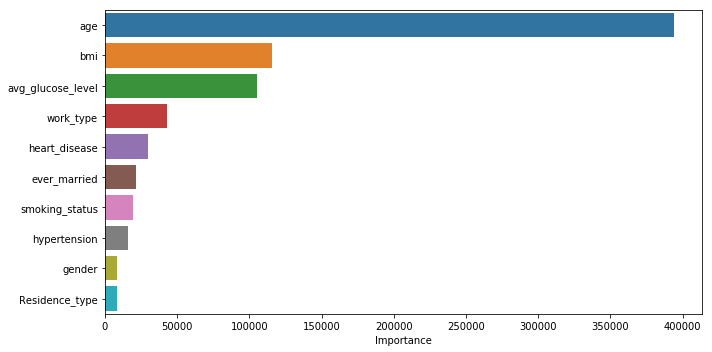

In [77]:
lgb_fscores=pd.DataFrame(lgb_tuned.feature_importances_)

feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_train.columns, lgb_tuned.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Importance'})

plt.figure(figsize=(10, 5))
importances=importances.sort_values(by='Importance', ascending=False)
sns.barplot(x='Importance', y=importances.index, data=importances)
plt.tight_layout()

The influence of each feature is roughly consistent with the insights got from data visualization. The rank of the features is similiar to that got from RandomForest classifier. The top three features are age, bmi(rank 3 in randomforest classifier) and avg_glucose_level. The bottom two features are gender and Residence_type.

### Feature selection

Select features based on the feature importance plot.

#### Remove Residence_type which has least influence on stroke.
Model perfomace on validation set can be improved slightly from ROC_AUC 0.827 to ROC_AUC 0.828. 

In [57]:
X_train_2=X_train.copy()
X_train_2 = X_train_2.drop(columns=['Residence_type'])

X_val_2=X_val.copy()
X_val_2 = X_val_2.drop(columns=['Residence_type'])

#### RandomForest classifier without Residence_type

In [58]:
def rf_evaluate( n_estimators, max_depth, min_samples_split, min_samples_leaf,max_leaf_nodes): 
    rf_params = {  'n_estimators': int(n_estimators),                                                              
                   'max_depth': int(max_depth),
                   'min_samples_split':int(min_samples_split), 
                   'min_samples_leaf':int(min_samples_leaf),
                   'max_leaf_nodes':int(max_leaf_nodes),
                   'n_jobs':-1, 
                   'random_state':42 
               }
     # Used around 1000 boosting rounds in the full model
    cv_result= cross_val_score(RandomForestClassifier(**rf_params, class_weight='balanced'),  ## ** unpack params for the function call
               X=X_train_2, 
               y=y_train, 
               cv=10,
               scoring='roc_auc',
               n_jobs=-1).mean()   
    return cv_result

rf_params = {"n_estimators": (10, 300),
            "max_depth": (3, 20),
            "min_samples_split": (2, 15),
            'min_samples_leaf':(2,20),
            "max_leaf_nodes": (20, 40)
            }


rf_bo = BayesianOptimization(rf_evaluate , rf_params)

rf_bo.maximize(init_points=5, n_iter=5, acq='ei')

|   iter    |  target   | max_depth | max_le... | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------
|  1        |  0.8512   |  17.74    |  36.56    |  16.17    |  4.649    |  20.41    |
|  2        |  0.8511   |  13.81    |  29.22    |  10.63    |  14.86    |  156.3    |
|  3        |  0.8513   |  13.44    |  26.69    |  11.86    |  4.941    |  226.4    |
|  4        |  0.8514   |  9.465    |  37.25    |  11.24    |  4.217    |  155.4    |
|  5        |  0.8473   |  4.891    |  27.53    |  7.707    |  8.011    |  252.1    |
|  6        |  0.8476   |  18.53    |  39.67    |  19.51    |  3.505    |  10.39    |
|  7        |  0.8519   |  19.48    |  38.34    |  15.81    |  10.48    |  299.9    |
|  8        |  0.8519   |  19.92    |  37.63    |  16.59    |  11.18    |  299.6    |
|  9        |  0.8521   |  19.52    |  39.87    |  19.52    |  5.946    |  298.9    |
|  10       |  0.8516   |  20.0     |  39.22    |  5.8

In [59]:
## get the best parameters 
rf_params = rf_bo.max['params']

print(rf_params)

{'max_depth': 19.51754867770845, 'max_leaf_nodes': 39.872644761324906, 'min_samples_leaf': 19.520142082013383, 'min_samples_split': 5.945889974588353, 'n_estimators': 298.897902335559}


In [60]:
rf_tuned = RandomForestClassifier(max_depth=19, 
                                  min_samples_split=5, 
                                  n_estimators= 298, 
                                  min_samples_leaf=19,
                                  max_leaf_nodes=39,
                                  class_weight='balanced')
                                 
rf_tuned = rf_tuned.fit(X_train_2, y_train)

rf_tuned_train_ROC_AUC = cross_val_score(rf_tuned, X_train_2, y_train, scoring='roc_auc').mean()
rf_tuned_val_ROC_AUC = cross_val_score(rf_tuned, X_val_2, y_val, scoring='roc_auc').mean()


print('train_rf_tuned ROC_AUC: {0:.3}'.format(rf_tuned_train_ROC_AUC))

print('val_rf_tuned ROC_AUC: {0:.3}'.format(rf_tuned_val_ROC_AUC))

train_rf_tuned ROC_AUC: 0.854
val_rf_tuned ROC_AUC: 0.828


#### Light GBM classifier without Residence_type
The model performance on validation set can be improved sightly from ROC_AUC 0.834 to ROC_AUC 0.84.

In [64]:
def lgb_evaluate( n_estimators, max_depth, learning_rate,colsample_bytree,subsample,reg_lambda): 
    lgb_params = {  'n_estimators': int(n_estimators),                                                              
                   'max_depth': int(max_depth),
                   'learning_rate':learning_rate,
                  'colsample_bytree':colsample_bytree,
                  'subsample':subsample,
                  'reg_alpha':0, #L1 regularization term on weights
                  'reg_lambda':reg_lambda, #L2 regularization term on weights
                   'n_jobs':-1, 
                   'random_state':42,
                  'objective':'binary',
                  'importance_type':'gain'
               }
     # Used around 1000 boosting rounds in the full model
    cv_result= cross_val_score(LGBMClassifier(**lgb_params, class_weight='balanced'),  ## ** unpack params for the function call
               X=X_train_2, 
               y=y_train, 
               cv=10,
               scoring='roc_auc',
               n_jobs=-1).mean()   
    return cv_result

lgb_params = {"n_estimators": (10, 300),
                  "max_depth": (3, 20),
                  'learning_rate':(0.01,0.03),
                  'colsample_bytree':(0.4,1),
                  'subsample':(0.4,1),
                  #'reg_alpha':(0,1),
                  'reg_lambda':(0,5)
             }


lgb_bo = BayesianOptimization(lgb_evaluate , lgb_params)

lgb_bo.maximize(init_points=5, n_iter=5, acq='ei')

|   iter    |  target   | colsam... | learni... | max_depth | n_esti... | reg_la... | subsample |
-------------------------------------------------------------------------------------------------
|  1        |  0.8581   |  0.4967   |  0.02687  |  16.88    |  188.1    |  2.343    |  0.6355   |
|  2        |  0.8527   |  0.6392   |  0.02722  |  7.27     |  29.52    |  1.198    |  0.8104   |
|  3        |  0.8591   |  0.5749   |  0.02054  |  4.385    |  236.9    |  3.237    |  0.4663   |
|  4        |  0.8513   |  0.7203   |  0.01192  |  5.555    |  63.71    |  2.082    |  0.6281   |
|  5        |  0.8562   |  0.7663   |  0.01376  |  12.72    |  228.1    |  1.412    |  0.5795   |
|  6        |  0.8536   |  0.8602   |  0.02883  |  19.97    |  300.0    |  3.908    |  0.7872   |
|  7        |  0.8552   |  0.5368   |  0.01415  |  3.448    |  213.0    |  4.983    |  0.8801   |
|  8        |  0.8568   |  0.6986   |  0.01607  |  3.144    |  236.0    |  0.01123  |  0.8833   |
|  9        |  0.855

In [65]:
## get the best parameters 
lgb_params = lgb_bo.max['params']

print(lgb_params)

{'colsample_bytree': 0.9450249877079677, 'learning_rate': 0.015114992754992595, 'max_depth': 3.3265461302020207, 'n_estimators': 295.6312652899903, 'reg_lambda': 0.022102006979337063, 'subsample': 0.42641310398133686}


In [99]:
lgb_tuned = LGBMClassifier(colsample_bytree=0.9450249877079677, 
                                   learning_rate= 0.015114992754992595, 
                                   max_depth= 3,
                                   n_estimators= 295,  
                                   reg_lambda= 0.022102006979337063, 
                                   subsample=  0.42641310398133686,
                                   class_weight='balanced',
                                   importance_type='gain',
                                   objective='binary')
                                 
lgb_tuned = lgb_tuned.fit(X_train_2, y_train)

lgb_tuned_train_ROC_AUC = cross_val_score(lgb_tuned, X_train_2, y_train, scoring='roc_auc', cv=10).mean()
lgb_tuned_val_ROC_AUC = cross_val_score(lgb_tuned, X_val_2, y_val, scoring='roc_auc',cv=10).mean()


print('train_lgb_tuned ROC_AUC: {0:.3}'.format(lgb_tuned_train_ROC_AUC))

print('val_lgb_tuned ROC_AUC: {0:.3}'.format(lgb_tuned_val_ROC_AUC))

train_lgb_tuned ROC_AUC: 0.859
val_lgb_tuned ROC_AUC: 0.84


When keep remove more features, there is no improvment for the model performance. So I would like to only remove Residence_type for the final model.

### Final Model 

Final model is light GBM classifier without Residence_type, which has the best performance on validation set.

#### Summary of models

In [97]:
model_eval=pd.DataFrame()
model_eval['Train ROC_AUC']=[0.854, 0.854, 0.858, 0.859]
model_eval['Val ROC_AUC']=[0.827, 0.828, 0.834, 0.84]
model_eval.rename(index={0:'RandomForest', 1:'RandomForest without Residence_type', 
                        2:'LGBM', 3:'LGBM without Residence_type'})

,Train ROC_AUC,Val ROC_AUC
RandomForest,0.854,0.827
RandomForest without Residence_type,0.854,0.828
LGBM,0.858,0.834
LGBM without Residence_type,0.859,0.840


#### Feature importance of final model

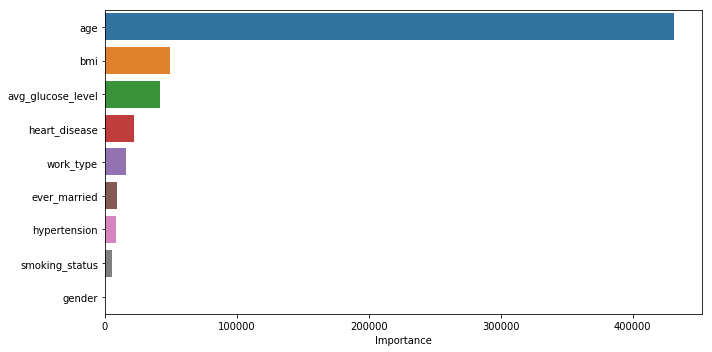

In [101]:
lgb_fscores=pd.DataFrame(lgb_tuned.feature_importances_)

feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_train_2.columns, lgb_tuned.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Importance'})

plt.figure(figsize=(10, 5))
importances=importances.sort_values(by='Importance', ascending=False)
sns.barplot(x='Importance', y=importances.index, data=importances)
plt.tight_layout()

## Prediction on test set

In [107]:
X_test=X_test.drop(columns=['Residence_type'])
y_pred = lgb_tuned.predict(X_test)

## Conclusion and future work

1. Based on the datasets in hand, the final model -- light GBM classifier without Residence_type has been built. The model I believe is good enough to provide some insights for clinical diagnosis.

2. The rank of features importance are much similiar with clinical observation.

3. The results also can provide ideas for people to descrease the risk of stroke, such as keeping excercise and eating health diet to avoid overweight/obese, taking medicine to control high blood presure, learning and practicing ways to reduce stress.

4. Smoking_status is not that important for stroke, which conflicts with clinical observation. These are around 30% missing values in smoking_status. Although I did imputation for those patient under 10, there are still 20 % missing. For better modeling and prediction in the future, smoking_status should be collected entirely.

Reference: https://www.wjmc.org/our-services/neuroscience/stroke-care/risk-factors/